In [1]:
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import warnings

# Set default settings.
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in data on NYC street trees.
df = pd.read_csv('./data/data_eda/data.csv.gz', compression='gzip')

# Read in data on New York City's streets for creating visualizations.
nyc_streets = gpd.read_file('./data/data_raw/nyc_streets/geo_export_f311eef5-5969-43eb-a781-39fa54d09b70.shp')

# Creating a new feature: The number of trees in a tree's proximity. 

In [3]:
# Turn geographic coordinates into Shapely objects.
trees = gpd.GeoDataFrame(df, geometry=[Point(coordinates) for coordinates in zip(df['longitude'], df['latitude'])])

# Define coordinate reference system (CRS) as WGS-84, then switch to a metric CRS.
trees.crs = {'init': 'epsg:4326', 'no_defs': True}
trees = trees.to_crs(epsg=3857)
trees.crs = {'init': 'epsg:3857', 'no_defs': True}

# Create circles with a 4.5m radius around each tree location. But since the radius of a tree might just touch another circle,
# the maximum distance between such trees should be 9m. This is also the upper minimal distance that should exist between trees.
buffers = trees.buffer(4.5)

# Set the Shapely objects for the circle to be in the WGS-84 CRS.
buffers = buffers.to_crs(epsg=4326)
buffers.crs = {'init': 'epsg:4326', 'no_defs': True}

# Switch the CRS again back to WGS-84.
trees = trees.to_crs(epsg=4326)
trees.crs = {'init': 'epsg:4326', 'no_defs': True}

In [4]:
# Turn the GeoSeries for the circles into a dataframe for a later sjoin.
circles = gpd.GeoDataFrame(buffers, geometry=buffers)
circles.rename(columns={0:'circles'}, inplace=True)
circles.drop('circles', axis=1, inplace=True)
circles['tree_id'] = trees['tree_id']
circles['tree_pos_lat'] = trees['latitude']
circles['tree_pos_long'] = trees['longitude']

# Create a copy of the tree circles to join the copy with the original. This results in overlapping circles.
circles_copied = circles.copy()

# Spatial join to find neighboring trees: Which circles of trees overlap?
neighbors = gpd.sjoin(circles,
                      circles_copied,
                      how='right',
                      op='intersects')
neighbors.drop(['index_left'], axis=1, inplace=True)

# Count neighboring trees per tree as new feature 'n_neighbors'.
n_neighbors = neighbors.groupby('tree_id_x').count()
n_neighbors.rename(columns={'tree_pos_lat_x': 'n_neighbors'}, inplace=True)
n_neighbors.drop(['tree_pos_long_x', 'geometry', 'tree_id_y', 'tree_pos_lat_y', 'tree_pos_long_y'], axis=1, inplace=True)
n_neighbors['n_neighbors'] = n_neighbors['n_neighbors'] - 1

# Add tree counts to data of each tree.
df_new = pd.merge(df, n_neighbors[['n_neighbors']], left_on='tree_id', right_index=True)

In [5]:
# Rename the columns to reflect the respective information.
neighbors.rename(columns={
                      'tree_pos_lat_x': 'lat',
                      'tree_pos_long_x': 'long',
                      'tree_pos_lat_y': 'neighbors_lat',
                      'tree_pos_long_y': 'neighbors_long'
                      },
                 inplace=True)

neighbors.reset_index(drop=True, inplace=True)

# Calculate the distance in meters between a tree and its neighboring tree(s).
neighbors['distance'] = [geodesic((neighbors['lat'].loc[i], neighbors['long'].loc[i]),
                                  (neighbors['neighbors_lat'].loc[i], neighbors['neighbors_long'].loc[i])).meters
                         for i in neighbors.index]

In [6]:
share_neighbors = len(neighbors[neighbors['distance'] > 0.0]) / len(circles)
print("{}% of all street trees in New York have a neighboring tree within 4.5m.".format(share_neighbors * 100))

34.12344176850135% of all street trees in New York have a neighboring tree within 4.5m.


In [7]:
# Of those trees with neighbors, identify average distance of a street tree to another street tree in New York.
avg_distance = neighbors[neighbors['distance'] > 0.0]['distance'].mean()
print("Of those street trees in New York with neighbors within 4.5m, the average distance to a neighboring tree is {}m.".format(avg_distance))

Of those street trees in New York with neighbors within 4.5m, the average distance to a neighboring tree is 5.292557226688078m.


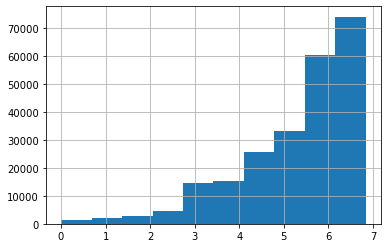

In [8]:
# Plot the distribution of the distance between neighboring trees. Finding: If two trees are neighbors, they are more than
# 4.5m away each other.
neighbors[neighbors['distance'] > 0.0]['distance'].hist()

In [9]:
# Encode the new feature 'n_neighbors'.
df_new.loc[df_new['n_neighbors'] == 0, 'n_neighbors'] = 0.1
df_new.loc[df_new['n_neighbors'] == 1, 'n_neighbors'] = 0.2
df_new.loc[df_new['n_neighbors'] >= 2, 'n_neighbors'] = 0.3

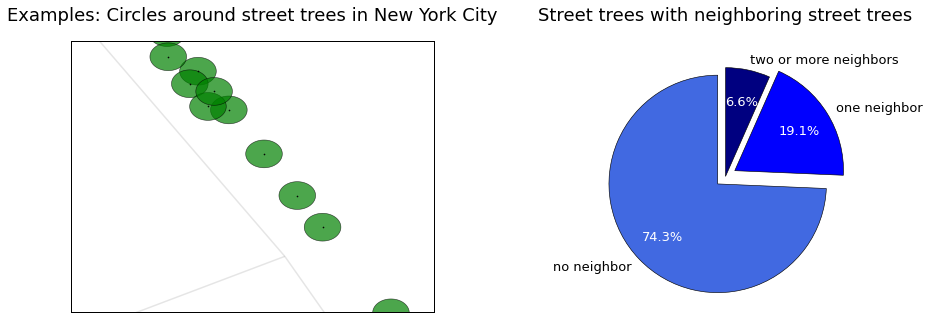

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

fig.subplots_adjust(wspace=0.3)

# Plot an example of a street tree and its surrounding circle.
fig_1 = buffers.plot(alpha=0.7, ax=axs[0], color='green', edgecolor='k', linewidth=0.6)
fig_1 = trees.plot(ax=axs[0], color='k', markersize=0.4)
fig_1 = nyc_streets.plot(ax=axs[0], alpha=0.2, color='grey')

fig_1.set_title('Examples: Circles around street trees in New York City', fontsize=18, pad=20)
axs[0].axis([-74.0048, -74.0040, 40.7077, 40.7083])
fig_1.spines['left'].set_linewidth(1)
fig_1.spines['left'].set_edgecolor('k')
fig_1.spines['right'].set_linewidth(1)
fig_1.spines['right'].set_edgecolor('k')
fig_1.spines['top'].set_linewidth(1)
fig_1.spines['top'].set_edgecolor('k')
fig_1.spines['bottom'].set_linewidth(1)  
fig_1.spines['bottom'].set_edgecolor('k')
axs[0].get_xaxis().set_ticks([])
axs[0].get_yaxis().set_ticks([])

# Plot the shares of how many street trees have no, one, or more than two neighboring trees. Most of the trees do not fullfill
# the city's tree planting requirements.
visual_data = df_new['n_neighbors'].copy()
no_neighbor = visual_data.loc[visual_data == 0.1].count()
one_neighbor = visual_data.loc[visual_data == 0.2].count()
twomore_neighbors = visual_data.loc[visual_data == 0.3].count()
sums = [no_neighbor, one_neighbor, twomore_neighbors]
categories = 'no neighbor', 'one neighbor', 'two or more neighbors'
highlight = (0.1, 0.1, 0)
axs[1].set_title('Street trees with neighboring street trees', fontsize=18, pad=20)
axs[1] = plt.pie(sums,
                 explode=highlight,
                 labels=categories,
                 colors=['royalblue','blue', 'navy'],
                 autopct='%1.1f%%',
                 pctdistance=0.7,
                 textprops={
                        'color': 'k',
                        'fontsize': 13
                        },
                 wedgeprops={
                        'edgecolor': 'k',
                        'linewidth': 0.6
                        },
                 startangle=90)
axs[1][2][0].set_color('white')
axs[1][2][1].set_color('white')
axs[1][2][2].set_color('white')

In [11]:
# Continue with encoding the new feature as a categorical variable.
df_new.loc[df_new['n_neighbors'] == 0.1, 'n_neighbors'] = "no neighbor"
df_new.loc[df_new['n_neighbors'] == 0.2, 'n_neighbors'] = "one neighbor"
df_new.loc[df_new['n_neighbors'] == 0.3, 'n_neighbors'] = "two or more neighbors"

In [12]:
# Selecting variables for features and the target ('health').
df_sel = df_new[['tree_id',
                 'steward',
                 'guards',
                 'sidewalk',
                 'root_stone',
                 'root_grate',
                 'root_other',
                 'trunk_wire',
                 'trnk_light',
                 'trnk_other',
                 'brch_light',
                 'brch_shoe',
                 'brch_other',
                 'n_neighbors',
                 'health']]

# One-hot encoding the categorical features and the target.
df_sel_enc = pd.get_dummies(df_sel)

# Inspecting target variables

In [13]:
# Merge data of trees with a poor or a fair health characteristic.
df_sel_enc['health_Poor|Fair'] = df_sel_enc['health_Poor'] + df_sel_enc['health_Fair']
df_sel_enc.drop(['health_Poor', 'health_Fair'], axis=1, inplace=True)

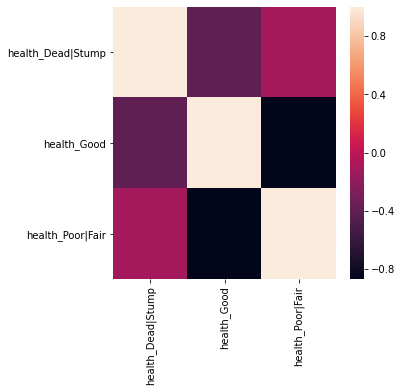

In [14]:
# Display correlations between target variables.
corrmat = df_sel_enc[list(df_sel_enc.columns)[32:]].corr()
plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, annot=False)
plt.show()

# Feature selection

Text(0.5, 1.0, 'Pearson correlation coefficients between features')

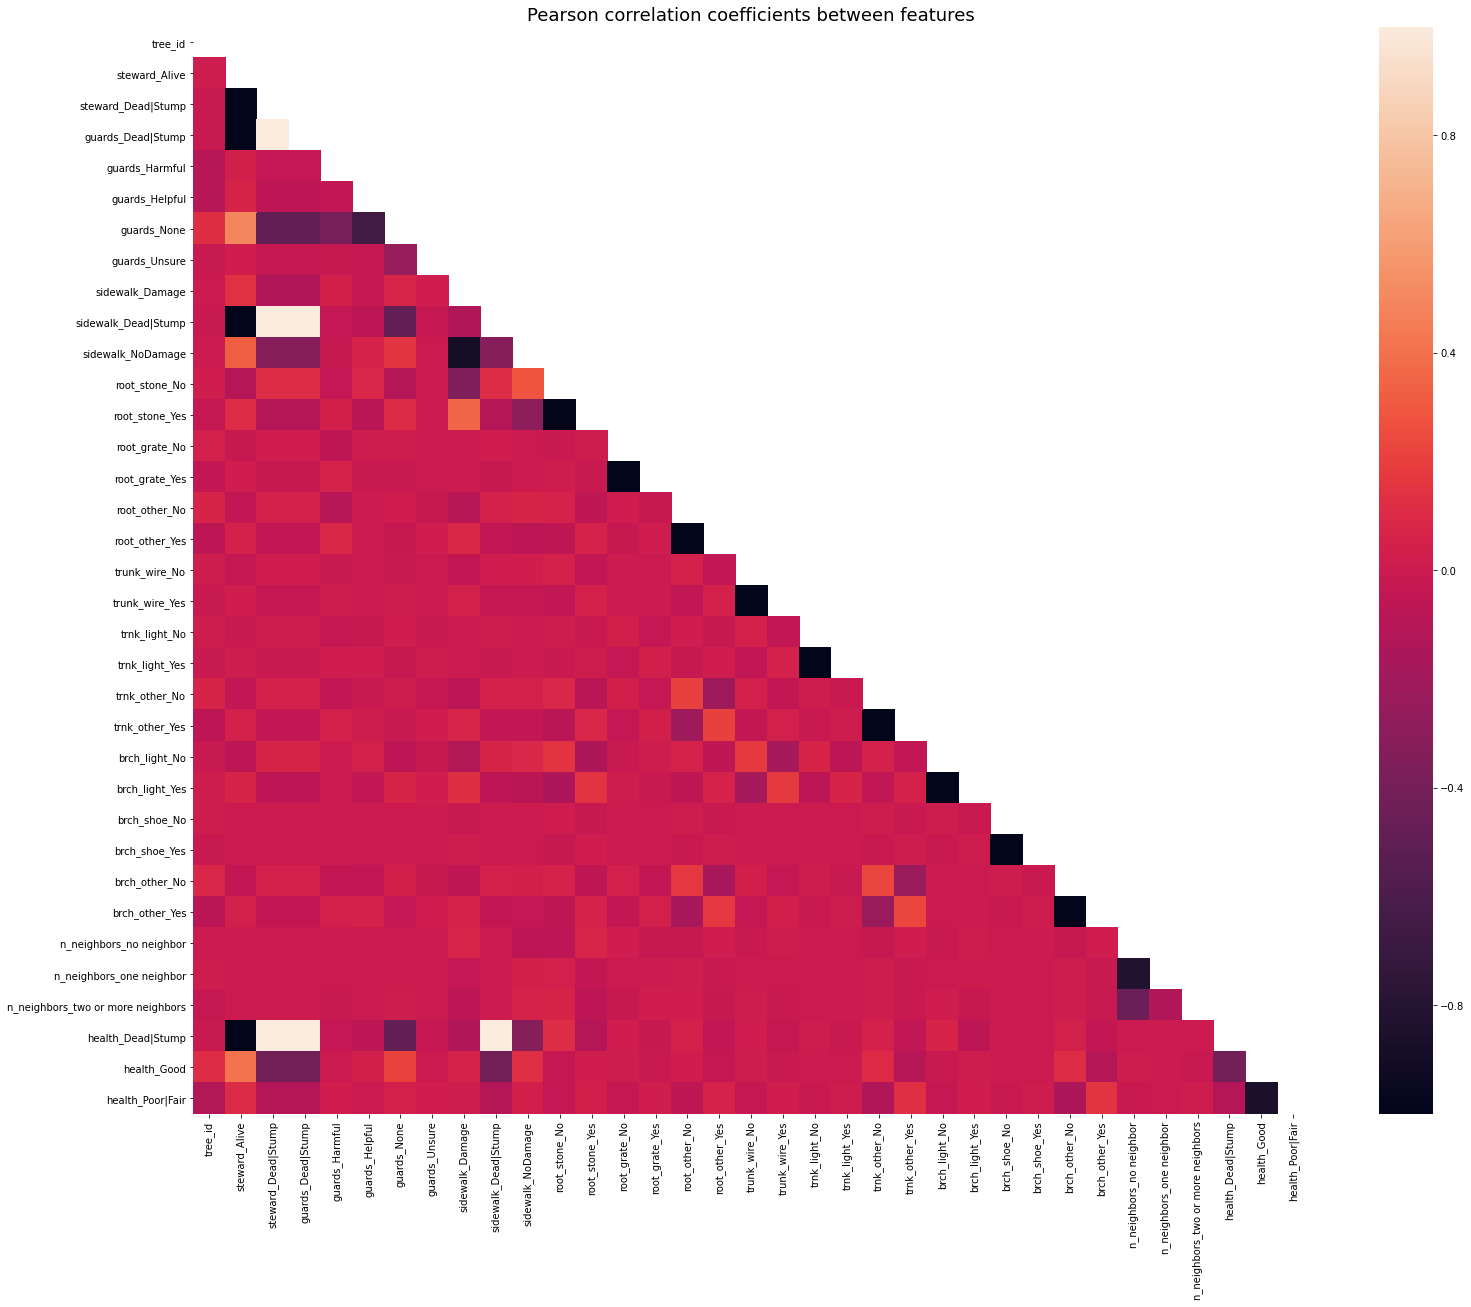

In [15]:
# Search for correlations between features (and target) categories.
corrmat = df_sel_enc.corr(method='pearson')
mask = np.triu(np.ones_like(corrmat, dtype=np.bool))
plt.subplots(figsize=(25, 20))
sns.heatmap(corrmat, annot=False, mask=mask)
plt.title('Pearson correlation coefficients between features', fontsize=18)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002089929C390>,
      dtype=object)

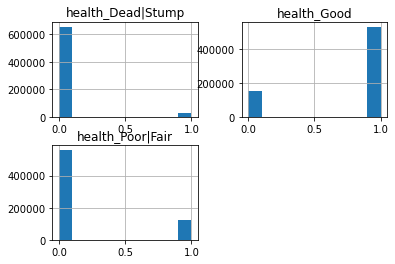

In [16]:
# Split into features and targets.
x = df_sel_enc[list(df_sel_enc.columns)[1:32]].values
y = df_sel_enc[list(df_sel_enc.columns)[32:]]

# Plot the data on the target.
y.hist()

In [17]:
# Conduct stratified splitting into training and testing datasets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=34, stratify=y)

In [18]:
# Run test with the RandomForestClassifier without balancing the dataset or hyperparameter tuning.
rdf_clf = RandomForestClassifier()
rdf_clf.fit(x_train, y_train)
y_pred = rdf_clf.predict(x_test)
print("The accuracy score for this run is:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=df_sel_enc.columns[32:]))

The accuracy score for this run is: 0.8219418884215576
                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.82      0.99      0.90    264425
 health_Poor|Fair       0.59      0.04      0.08     61661

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.80      0.68      0.66    341894
     weighted avg       0.78      0.82      0.75    341894
      samples avg       0.82      0.82      0.82    341894



In [19]:
# Inspect the importance of each feature.
feature_imp = pd.Series(rdf_clf.feature_importances_, index=df_sel_enc.columns[1:32]).sort_values(ascending=False)
print(feature_imp)

sidewalk_Dead|Stump                  0.238792
steward_Dead|Stump                   0.213249
steward_Alive                        0.186682
guards_Dead|Stump                    0.173445
brch_other_No                        0.031024
brch_other_Yes                       0.026096
sidewalk_NoDamage                    0.024128
trnk_other_No                        0.020596
trnk_other_Yes                       0.020144
guards_None                          0.018520
guards_Helpful                       0.004741
sidewalk_Damage                      0.004026
root_other_No                        0.003326
root_stone_No                        0.003022
root_other_Yes                       0.003003
root_stone_Yes                       0.002816
n_neighbors_two or more neighbors    0.002636
n_neighbors_no neighbor              0.002565
guards_Harmful                       0.002454
brch_light_No                        0.002410
n_neighbors_one neighbor             0.002319
brch_light_Yes                    

In [20]:
# Training & pruning with model-based feature selection.
rdf_clf_sm = SelectFromModel(RandomForestClassifier(random_state=None), threshold='median')
rdf_clf_sm.fit(x_train, y_train)
x_train_fs = rdf_clf_sm.transform(x_train)
x_test_fs = rdf_clf_sm.transform(x_test)

rdf_clf_n = RandomForestClassifier(random_state=None).fit(x_train_fs, y_train)
y_pred_fs = rdf_clf_n.predict(x_test_fs)
accuracy = rdf_clf_n.score(x_test_fs, y_test)
print("Accuracy score:", accuracy)

Accuracy score: 0.8223250481143278


# Export feature / target dataframe as .csv file

In [21]:
df_sel_enc.to_csv('./data/data_preprocessed/features.csv.gz', compression='gzip', index=False)